In [1]:
%reload_ext autoreload
%autoreload 2

1. download all parts of helen data - combine all into train folder (should hve 2330)
2. rename annotation files with image (1.txt -> 100032540_1_anno.txt)

In [2]:
from fastai.vision import *
from fastai.datasets import *

### Download Helen Facepoint Data

In [3]:
path = Path('/home/sudosharma/projects/data/helen/')

### Rename annotation files

In [31]:
def rename_anno_files(anno_path):
    for anno in anno_path.ls():
        if anno.stem.find('anno') > 0: 
            return
        with open(anno) as f:
            fname = f.readline().strip()
        anno.rename(anno.parent / f'{fname}_anno.txt')
    return

In [32]:
rename_anno_files(path/'annotation')

### Prep Dataloader

In [6]:
def _get_size(xs,i):
    size = xs.sizes.get(i,None)
    if size is None:
        # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

class CustomPointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList): self.c = 136
    def process(self, ds:ItemList):  ds.c = self.c

class CustomPointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = CustomPointsProcessor

    def __post_init__(self): self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return ImagePoints(FlowField(_get_size(self.x,i), o), scale=True)

    def analyze_pred(self, pred, thresh:float=0.5): return pred.view(-1,2)
    def reconstruct(self, t, x): return ImagePoints(FlowField(x.size, t), scale=False)

In [9]:
def get_annos(o):
    anno = path/'annotation'/f'{o.stem}_anno.txt'
    points = []
    with open(anno) as f:
        for line in f:
            points.append([float(coord) for coord in line.strip().split(',')][::-1])
    points = torch.Tensor(points[59:])
    return points

def get_data(sz=512, bs=1, path=path):
    return (PointsItemList.from_folder(path)
            .split_by_rand_pct(0.1)
            .label_from_func(get_annos, label_cls=CustomPointsLabelList)
            .transform(get_transforms(), tfm_y=True, size=sz)
            .databunch(bs=bs))

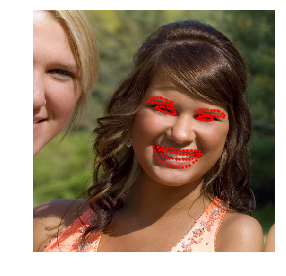

In [11]:
data = get_data()
data.show_batch()